# Class 9 - Kernelized SVM

## Non-linear problems

In the last class we have seen how to train soft-margin SVM in order to find linear separators in case our datasets are not strictly linearly separable. 

There are cases, however, in which the two classes are impossible to separate linearly not just because of random noise, but because there is an inherent underlying non-linearity at play.

In other words, we want to look for non-linear separators for our clusters of points.

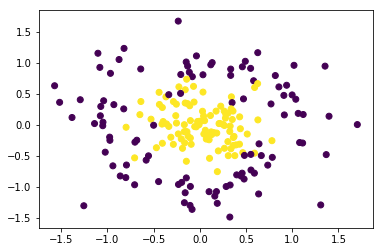

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Concentric circles
x, y = datasets.make_circles(n_samples=200, shuffle=True, noise=0.3, random_state=2, factor=0.1)
x = x 
y = 2*y-1

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In the example above, one may try to represent the points in polar coordinates, so that we can linearly separate the yellow points close to the origin from the blue points far from the origin.

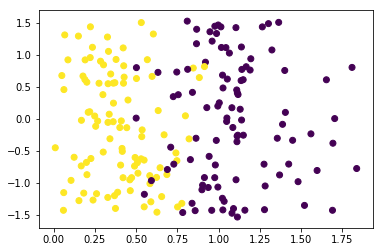

In [2]:
# Concentric circles
r = np.sqrt(x[:,0]**2 + x[:,1]**2)
theta = np.arctan(x[:,1]/x[:,0])

plt.scatter(r, theta, c=y)
plt.show()

Or one may try to pass to a higher dimensional space, hoping that the extra dimensions will make it possible to find a good separation. 

For example we might try the following features transformation: $(x^{(1)}, x^{(2)}) \to (x^{(1)}, x^{(2)}, ({x^{(1)}})^2 + ({x^{(2)}})^2)$.

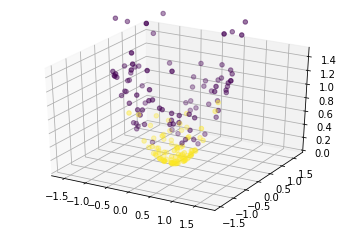

In [3]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,0]**2 + x[:,1]**2, c=y)
ax.set_zlim(0,1.5)

plt.show()

The idea is therefore to find a "smart" transformation or, equivalently, a feature extension, $\psi: \mathcal{X} \to \mathcal{H}$, from our feature space, $\mathcal{X}$, to another (possibly higher-dimensional) feature space, $\mathcal{H}$, such that the problem becomes linearly separable in the new space.

## Feature space embeddings

Unfortunately moving to a higher dimensional space can be computationally very expensive.

We have encountered similar problems already in the case of polynomial regression, where constructing even low degree multivariate polynomials can lead to an explosion in the number of parameters to be estimated and correspondingly in the computational time of the optimization task. 

The use of **kernels** is a way of overcoming this problem of computational intractability, whenever we have to move to high dimensional spaces. 

The method is very general and is used for many ML models, but we will now see it in the particular context of SVMs, so as to understand it in a more concrete setting.

Remember that our Regularized Loss Minimization formulation for the soft-margin SVM required us to solve the following problem:

$$ \underset{w \in \mathcal{X}}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w\right\|^2 + \frac{1}{n} \sum_{i=1}^n \max \{ 0, 1 - y_i \langle w, x_i \rangle \},$$ 

where we have extend the features by adding a column of ones, $x \to (1, x)$, to get rid of the bias term, $b$.

Supposed now that we were to apply a given transformation $\psi: \mathcal{X} \to \mathcal{H}$ to pass to a higher dimensional feature space, hoping that the problem becomes linearly separable there. 

Then in order to implement SVM in $\mathcal{H}$ we would have to solve the following high-dimensional problem:

$$ \underset{w \in \mathcal{H}}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w\right\|^2 + \frac{1}{n} \sum_{i=1}^n \max \{ 0, 1 - y_i \langle w, \psi(x_i) \rangle \}.$$

Using Stochastic Gradient Descent the update rule for $w$ is:

$$ w^{(t+1)} = w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)} + \nu^{(t)}) = \begin{cases} w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)} -y_i \psi(x_i)), & \text{if $y_i \langle w, \psi(x_i) \rangle < 1$}, \\ w^{(t)} - \frac{1}{\lambda t} \lambda w^{(t)}, & \text{otherwise,} \end{cases} $$

where $(x_i, y_i)$ is a randomly sampled point from the training dataset and $\nu^{(t)}$ is the subgradient of the hinge-loss function at the $t$-th step.

The problem is high-dimensional because $w$ now lives in the space $\mathcal{H}$, so that the optimization problem has become computationally much more expensive. 

We can nevertheless use the following theorem, which tells us that all the solutions to our problem have a particularly simple representation.

## The kernel trick

#### Representer Theorem

Let $w^*$ be a solution to the soft-margin SVM problem, i.e.

$$w^* = \underset{w \in \mathcal{H}}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w\right\|^2 + \frac{1}{n} \sum_{i=1}^n \max \{ 0, 1 - y_i \langle w, \psi(x_i) \rangle \}$$

then $w^* = \sum_{j=1}^n \alpha_j \psi(x_j)$, that is $w^*$ is a linear combination of the vectors $(\psi(x_i))_{i=1}^n$.

**Proof:** 

Let $w^*$ be a solution to the optimization problem. Without loss of generality we can represent $w^*$ in the following way:

$$w^* = w + u = \sum_{j=1}^n \alpha_j \psi(x_j) + u,$$

where $u$ is orthogonal to $w$, that is $\langle u, \psi(x_j) \rangle = 0$, for all $j \in [n]$.

Then $\|w^*\|^2 = \|w\|^2 + \|u\|^2$, so that $\|w\|^2 \le \|w^*\|^2$. This in particular implies that if $w^*$ minimizes the margin term in the regularized loss function, so does $w$.

Furthermore $\langle w^*, \psi(x_j) \rangle = \langle w + u, \psi(x_j) \rangle = \langle w, \psi(x_j) \rangle + \langle u, \psi(x_j) \rangle = \langle w, \psi(x_j) \rangle$, so that the hinge-loss term in the regularized loss function is the same for both $w^*$ and $w$.

We conclude that $w$ is an optimal solution and therefore $w^*$ must have the required form.


_______________________________________________________________________________________________________________

Using the explicit representation for $w$ given by the Representer Theorem, we can reformulate the soft-margin SVM problem in the following way:

$$ \underset{(\alpha_j)_{j=1}^n}{\text{argmin}} \:\: \frac{\lambda}{2} \left\| \sum_{j=1}^n \alpha_j \psi(x_j) \right\|^2 + \frac{1}{n} \sum_{i=1}^n \max \left\{ 0, 1 - y_i  \sum_{j=1}^n \alpha_j \langle \psi(x_j), \psi(x_i) \rangle \right\},$$

where the minimization now takes place only on the coefficients $\alpha_j$, for $j = 1, \ldots, n$, which is a substantial dimensionality reduction.

We can also rewrite the SGD update step by using $w$'s representation:

$$ \sum_{j=1}^n \alpha^{(t)}_j \psi(x_j) = \begin{cases} \sum_{j=1}^n \alpha^{(t-1)}_j \psi(x_j) - \frac{1}{\lambda t} \left( \lambda \sum_{j=1}^n \alpha^{(t-1)}_j \psi(x_j) - y_i \psi(x_i) \right) & \text{if $y_i \sum_{j=1}^n \alpha^{(t-1)}_j \langle \psi(x_j), \psi(x_i) \rangle < 1$}\\ \sum_{j=1}^n \alpha^{(t-1)}_j \psi(x_j) - \frac{1}{\lambda t} \lambda \sum_{j=1}^n \alpha^{(t-1)}_j \psi(x_j) & \text{otherwise} \end{cases}$$ 

and notice that it is enough to keep track of the changes in the coefficients $(\alpha_j)_{j=1}^n$:

$$ \alpha^{(t)}_j= \begin{cases} \alpha^{(t-1)}_j - \frac{1}{\lambda t} \left( \lambda \alpha^{(t-1)}_j  - y_i \delta_{i,j} \right) & \text{if $y_i \sum_{j=1}^n \alpha^{(t-1)}_j \langle \psi(x_j), \psi(x_i) \rangle < 1$}\\  \alpha^{(t-1)}_j - \frac{1}{\lambda t} \lambda \alpha^{(t-1)}_j  & \text{otherwise} \end{cases}$$ 

Notice that now we are optimizing on an $n$-dimensional vector space (the size of our training dataset), therefore we are not working anymore on the high-dimensional space $\mathcal{H}$.

Moreover, we are never actually required to compute explicitly the transformation $\psi$ at any point, because the transformed features, $\psi(x)$, only appear within inner product formulas. 

More precisely, the only quantities that we need to compute efficiently are:

+ the $n$-times-$n$ inner products $\langle \psi(x_j), \psi(x_i) \rangle$, needed for training (see SGD update step above), and 
+ the inner product $\langle \psi(x_j), \psi(x) \rangle$, needed for prediction, because ultimately we must be able to compute our predicted labelling $\text{sign}\left( \langle w, \psi(x) \rangle \right) = \text{sign}\left( \sum_{j=1}^n \alpha_j \langle \psi(x_j), \psi(x) \rangle \right)$, for new instances $x$, once we have found the optimal $(\alpha_j)$.

Notice that, in general, computing these inner products in the high-dimensional feature space $\mathcal{H}$ is computationally very demanding. 

But both computations can be efficiently performed once we can specify the function $K(x, x') = \langle \psi(x), \psi(x') \rangle$, which allows us to compute the inner product on $\mathcal{H}$ directly on the space $\mathcal{X}$, without ever actually computing the transformation $\psi$. 

Functions such as $K$ are called kernels.

## Kernels and prior knowledge

The following are two of the most commonly used kernels:

**Polynomial kernel:** $K(x, x') = (C + \langle x, x' \rangle)^p$, where $x,x' \in \mathbb{R}^d$, $C \in \mathbb{R}$ is a constant and $p$ is the degree of the multivariate polynomial representation. This kernel represents the inner product in the space of polynomial features.

In order to see this, for simplicity take the case where $x \in \mathbb{R}$, $C=1$, and $p=2$, then if we let $\psi(x) = (1, \sqrt{2} x, x^2)$ be our polynomial feature extension, we obtain:

$$\langle \psi(x), \psi(x') \rangle = \langle (1, \sqrt{2}x, x^2), (1, \sqrt{2}x', x'^2) \rangle = 1 + 2xx' + x^2x'^2 = (1 + xx')^2$$

**Gaussian (or Radial Basis Function) kernel:** $K(x, x') = \text{exp}\left(-\frac{\|x - x'\|^2}{2}\right)$, where $x,x' \in \mathbb{R}^d$. This kernel represents the inner product in an infinite-dimensional Hilbert space $\mathcal{H}$, reached via the transformation $\psi$ given by the coordinates $\frac{1}{\sqrt{(p_1+\dotsb+p_d)!}} \prod_{j=1}^d (x_j)^{p_j} e^{-x_j^2/2}$, for $p_1, \dotsc, p_d \in \mathbb{N}_0$.

Notice that in both cases the transformations $\psi$ are exceedingly complex and the inner products $\langle \psi(x), \psi(x') \rangle$ are either computationally demanding or even impossible in the space $\mathcal{H}$, while the kernel functions are mathematically very simple in the space $\mathcal{X}$.

Therefore the kernel trick allows us to use the representational complexity of linear separators in very high-dimensional (or even infinite-dimensional) spaces at a computational cost that scales with the size of your dataset, depending on the computability of the kernel function $K$.

Of course the choice of a particular kernel amounts to impose some a priori assumptions on the kind of non-linearity present in our dataset. 

Moreover, as the No-Free Lunch theorem implies, there is no single kernel that performs best in all tasks, therefore the choice of the kernel to use in a kernelized SVM is largely a matter of prior knowledge or model assumptions.

The standard practice is to test the performance of several different kernels on a dataset. In some cases one may also consider developing one's own, non-standard kernel (necessary and sufficient conditions for a function $K(\cdot, \cdot)$ to represent an inner product in some Hilbert space are known, see Mercer's theorem for more details).

## Kernelized-SVM: implementation

Below we show the algorithmic implementation for training a kernelized SVM, solved using the RLM approach via SGD and subgradients:

$\quad \quad \quad$ **Kernelized SVM**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$.

**Initialize**: $\alpha^{(1)} = (0, \ldots, 0)$.

**for** $t = 1, 2, 3, \ldots, T$:

$\quad$ Choose $i$ uniformly at random from $\{1, 2, \ldots, n\}$.

$\quad$ **if** $\:\: y_i \sum_{j=1}^n \alpha^{(t)}_j K(x_j, x_i) < 1$:

$\quad \quad$ $\alpha^{(t+1)}_j = \alpha^{(t)}_j - \frac{1}{\lambda t} \left( \lambda \alpha^{(t)}_j  - y_i \delta_{i,j} \right)$

$\quad$ **else**:

$\quad \quad$ $\alpha^{(t+1)}_j = \alpha^{(t)}_j - \frac{1}{\lambda t} \left( \lambda \alpha^{(t)}_j  \right).$

**return**: $ \left(\alpha^{(T)}_j\right)_{j=1}^n$

Notice that the algorithm does not return the vector $w \in \mathcal{H}$, but rather the coefficients of its linear representation $w = \sum_{j=1}^n \alpha_j \psi(x_j)$. As discussed before returning $w$ would be computationally challenging or even impossible (as in the case in which $\mathcal{H}$ is infinite-dimensional).

These coefficients will then be used for prediction on a new instance $x \in \mathcal{X}$ via the formula:

$$ y = \text{sign} \left( \langle w, \psi(x)\rangle \right) = \text{sign} \left( \sum_{j=1}^n \alpha_j K(x_j, x) \right). $$

We implement the polynomial and Radial Basis Functions kernels. They can be chosen at run-time by commenting/uncommenting the relevant part of the code.

In [4]:
def kernel(t, s):
    # Polynomial
    output = (1. + t.dot(s))**2
    
    # Radial Basis Function
    # output = np.exp(-(np.linalg.norm(t - s)**2)/2)
    return output

def zero_one_loss(y_true, y_pred):
    n = y_true.shape[0]
    return (1/n) * np.sum(y_true != y_pred)

Below are the training and prediction routines.

In [5]:
def kernelized_svm_train(x, y, l=1.0, verbose=False, max_iter = 10**4):
    
    n, d = x.shape
    
    alpha = np.zeros(n)
    
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel(x[i,:], x[j,:])
    
    i = 1
    while i < max_iter:
        # print(alpha)
        if verbose:
            print(i)

        random_index = np.random.randint(0, n)
        
        if y[random_index]*np.transpose(K).dot(alpha)[random_index] < 1:
            subgradient = l*alpha 
            subgradient[random_index] = subgradient[random_index] - y[random_index]
            alpha = alpha - (1/(l*i))*subgradient
        else:
            subgradient = l*alpha 
            alpha = alpha - (1/(l*i))*subgradient
        
        i = i + 1
    if verbose:
        print("Iterations: ", i)
    return alpha

def kernelized_svm_predict(new_instance, x, alpha):
    n, d = x.shape
    
    v = np.zeros(n)
    for i in range(n):
        v[i] = kernel(x[i, :], new_instance)

    output = np.sign(alpha.dot(v))
    
    return output

In [6]:
alpha = kernelized_svm_train(x, y, l=0.1, verbose=False, max_iter=10**5)

Our kernelized SVM is a linear separator in the space $\mathcal{H}$, but in the original feature space $\mathcal{X}$ it will not appear as a line, therefore we cannot show the classification boundary of our model by a simple line plot, as we did for linear SVM.

We will instead compute the predicted labels for each point in a (sufficiently fine) grid and color that point yellow if the predicted label is $+1$, while coloring it blue if the predicted label is $-1$.

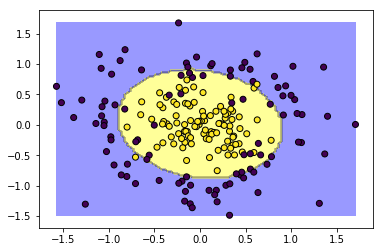

Training error: 0.105


In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

N = 100

t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), N)
s = np.linspace(np.min(x[:,1]), np.max(x[:,1]), N)

Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = kernelized_svm_predict(np.array([t[i],s[j]]), x, alpha)

X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, Z, colors=('blue', 'yellow'), alpha=0.4)
plt.scatter(x[:,0], x[:,1], c=y, edgecolor='k')
plt.show()


# Compute training error
n, d = x.shape
y_pred = np.zeros(n)
for i in range(n):
    y_pred[i] = kernelized_svm_predict(x[i,:], x, alpha)
print('Training error:', zero_one_loss(y, y_pred))

## Kernelized-SVM: scikit-learn implementation

The package sklearn also provides an implementation of kernelized SVM. For more information, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

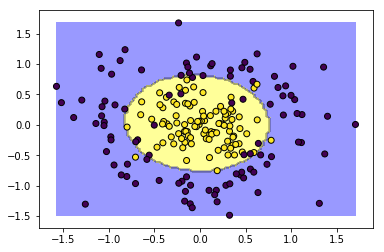

Training error: 0.075


In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

clf = svm.SVC(gamma='auto', kernel='poly', degree=2)
clf.fit(x, y)

N = 100

t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), N)
s = np.linspace(np.min(x[:,1]), np.max(x[:,1]), N)

Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = clf.predict(np.array([[t[i],s[j]]]))

X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, Z, colors=('blue', 'yellow'), alpha=0.4)
plt.scatter(x[:,0], x[:,1], c=y, edgecolor='k')
plt.show()

# Compute training error
y_pred = clf.predict(x)
print('Training error:', zero_one_loss(y, y_pred))

By generating datasets that are more and more non-linear, one can really appreciate the power of SVM for binary classification.

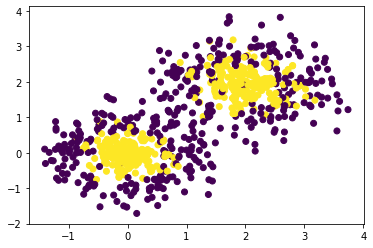

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

x_one, y_one = datasets.make_circles(n_samples=400, shuffle=True, noise=0.4, random_state=2, factor=0.1)
x_one = x_one + 2
x_two, y_two = datasets.make_circles(n_samples=400, shuffle=True, noise=0.3, random_state=2, factor=0.1)

x = np.vstack((x_one, x_two))
y = np.hstack((y_one, y_two))
y = 2*y-1


plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

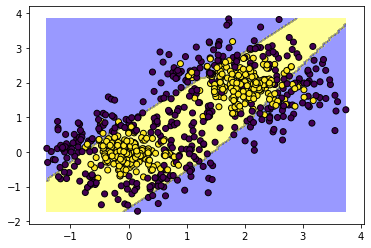

NameError: name 'zero_one_loss' is not defined

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# clf = svm.SVC(gamma='auto', kernel='rbf')
clf = svm.SVC(gamma='auto', kernel='poly' , degree=4)
clf.fit(x, y)

N = 100

t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), N)
s = np.linspace(np.min(x[:,1]), np.max(x[:,1]), N)

Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = clf.predict(np.array([[t[i],s[j]]]))

X, Y = np.meshgrid(t, s)
plt.contourf(X, Y, Z, colors=('blue', 'yellow'), alpha=0.4)
plt.scatter(x[:,0], x[:,1], c=y, edgecolor='k')
plt.show()

# Compute training error
y_pred = clf.predict(x)
print('Training error:', zero_one_loss(y, y_pred))

## Practice yourself!

+ The sklearn implementation of SVM has a Radial Basis Functions kernel of the following form:
$$K(x,x') = \text{exp}\left(-\gamma \|x - x'\|^2\right)$$
Use cross-validation for selecting the optimal value for the hyperparameter $\gamma$. What happens for very high values of $\gamma$? Why?
+ Learn the Titanic dataset using kernelized SVM. What kernel performs the best? Is your SVM implementation better than logistic regression and decision trees?
+ Can you find a new kernel function to implement? Test it on an artificial dataset and compare its performance.
+ Take the last dataset in the notebook (the two clusters). What happens if you try to fit a SVM with polynomial kernel of degree 2? Why?